In [1]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

In [2]:
mp_face_detection = mp.solutions.face_detection

face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)

mp_drawing = mp.solutions.drawing_utils

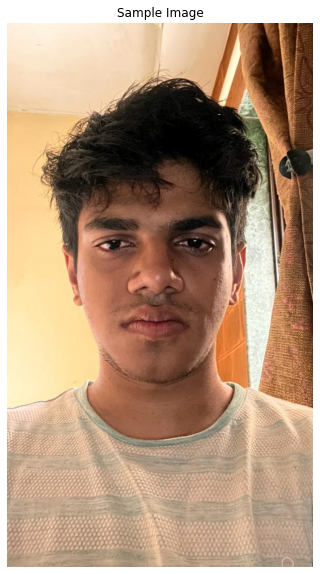

In [4]:
sample_img = cv2.imread('chinu.jpeg')

plt.figure(figsize = [10, 10])

plt.title("Sample Image");plt.axis('off');plt.imshow(sample_img[:,:,::-1]);plt.show()

In [44]:
face_detection_results = face_detection.process(sample_img[:,:,::-1])

if face_detection_results.detections:

    for face_no, face in enumerate(face_detection_results.detections):

        face_data = face.location_data
        
        l = face_data.relative_keypoints[mp_face_detection.FaceKeyPoint(4).value].x
        r = face_data.relative_keypoints[mp_face_detection.FaceKeyPoint(5).value].x
        u = face_data.relative_keypoints[mp_face_detection.FaceKeyPoint(4).value].y
        d = face_data.relative_keypoints[mp_face_detection.FaceKeyPoint(2).value].y


FACE NUMBER: 1
FACE CONFIDENCE: 0.94
nFACE BOUNDING BOX:nxmin: 0.19547457
ymin: 0.3250212
width: 0.56967354
height: 0.32041925

RIGHT_EYE:
x: 0.36745512
y: 0.41006204

LEFT_EYE:
x: 0.6002815
y: 0.4095809

NOSE_TIP:
x: 0.486319
y: 0.4870647

MOUTH_CENTER:
x: 0.48362023
y: 0.55297315

RIGHT_EAR_TRAGION:
x: 0.23334748
y: 0.4433354

LEFT_EAR_TRAGION:
x: 0.7238217
y: 0.44445992



In [47]:
d - u
d = d + (d - u)

In [48]:
l = int(sample_img.shape[1]*l)
r = int(sample_img.shape[1]*r)
u = int(sample_img.shape[0]*u)
d = int(sample_img.shape[0]*d)

In [49]:
sample_img.shape[1]

576

In [50]:
sample_img.shape[0]

1024

In [51]:
print(l,r,u,d)

134 416 453 543


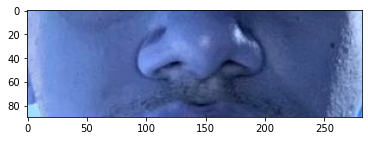

In [52]:
img = sample_img[u:d,l:r]
plt.imshow(img)

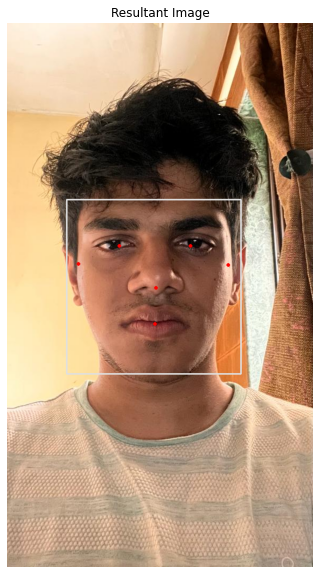

In [7]:
'''
img_copy = sample_img[:,:,::-1].copy()

if face_detection_results.detections:

    for face_no, face in enumerate(face_detection_results.detections):

        mp_drawing.draw_detection(image=img_copy, detection=face, 
                                 keypoint_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0),
                                                                              thickness=2,
                                                                              circle_radius=2))
fig = plt.figure(figsize = [10, 10])

plt.title("Resultant Image");plt.axis('off');plt.imshow(img_copy);plt.show()
'''

# BPM

In [56]:
import cv2
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.fft import fft
import scipy.signal as signal
import operator 

In [57]:
def extractReg(sample_img):
    
    face_detection_results = face_detection.process(sample_img[:,:,::-1])

    if face_detection_results.detections:

        for face_no, face in enumerate(face_detection_results.detections):

            face_data = face.location_data

            l = face_data.relative_keypoints[mp_face_detection.FaceKeyPoint(4).value].x
            r = face_data.relative_keypoints[mp_face_detection.FaceKeyPoint(5).value].x
            u = face_data.relative_keypoints[mp_face_detection.FaceKeyPoint(4).value].y
            d = face_data.relative_keypoints[mp_face_detection.FaceKeyPoint(2).value].y
    
    
    d - u
    d = d + (d - u)
    
    l = int(sample_img.shape[1]*l)
    r = int(sample_img.shape[1]*r)
    u = int(sample_img.shape[0]*u)
    d = int(sample_img.shape[0]*d)
    
    return sample_img[u:d,l:r]

In [58]:
input_video_path = 'vid.avi'


intensities = []
frames = []

cap = cv2.VideoCapture(input_video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
#fps is the global variable for frames per second

while(cap.isOpened()):
    ret, frame = cap.read()
 
    if ret:
        frame = extractReg(frame)
        frames.append(frame)
        #intensities.append(np.mean(frame))
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
            
    else:
        break
        
cap.release()
cv2.destroyAllWindows()

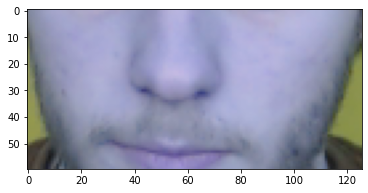

In [65]:
plt.imshow(frames[456])

In [66]:
greenIntensities = []
for frame in frames:
    greenIntensities.append(np.mean(frame[:,:,1]))

In [69]:
time = np.arange(len(greenIntensities))/fps

Text(0.5, 1.0, 'Green Channel')

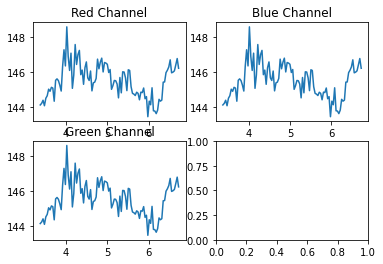

In [70]:
figure, axis = plt.subplots(2, 2)
  

axis[0, 0].plot(time[100:200], greenIntensities[100:200])
axis[0, 0].set_title("Red Channel")
  

axis[0, 1].plot(time[100:200], greenIntensities[100:200])
axis[0, 1].set_title("Blue Channel")
  

axis[1, 0].plot(time[100:200], greenIntensities[100:200])
axis[1, 0].set_title("Green Channel")

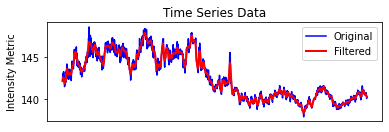

In [71]:
def butterFilter(data, order=2, cutoff=0.15, FPS=fps):
    cutoff = 0.15*30/int(FPS)
    if cutoff > 1:
        cutoff = 0.9
    B, A = signal.butter(order, cutoff, output='ba')
    return signal.filtfilt(B,A, data)

greenIntensitiesf = butterFilter(greenIntensities)
time = np.linspace(0, int(len(greenIntensities)/fps), len(greenIntensities), endpoint=False)


fig = plt.figure()
ax1 = fig.add_subplot(211)
plt.plot(time,greenIntensities, 'b-')
plt.plot(time,greenIntensitiesf, 'r-',linewidth=2)
plt.ylabel("Intensity Metric")
plt.legend(['Original','Filtered'])
plt.title("Time Series Data")
ax1.axes.get_xaxis().set_visible(False)

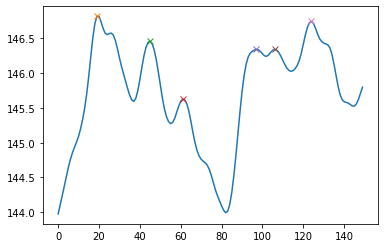

In [72]:
x = greenIntensitiesf[100:250]
peaks = find_peaks(x, distance=9)[0]
plt.plot(x)
for peak in peaks:
    plt.plot(peak, x[peak], "x")
plt.show()

In [73]:
def bpmDFT(data, FPS, seconds=5, stride=1):
    bpmList = []
    i = 0
    windowSize = int(FPS*seconds)
    stepSize = int(FPS*stride)
    
    while( (windowSize + i*stepSize) < len(data)):
        data1 = data[0 + i*stepSize : windowSize + i*stepSize]
        n = len(data1)                       # length of the signal
        k = np.arange(n)
        T = n/FPS
        frq = k/T 
        Y = abs(np.fft.fft(data1))              # fft computing and normalization


        #plt.plot(frq[1:100], Y[1:100], 'r-')
        #plt.xlabel('freq (Hz)')
        #plt.ylabel('|Y(freq)|')
        #plt.show() 

        frqN = frq[np.where(np.logical_and(frq>=1, frq<=3))]
        YN = Y[np.where(np.logical_and(frq>=1, frq<=3))]

        bpmList.append(frqN[np.argmax(YN)]*60)
        
        i += 1
    
    return bpmList

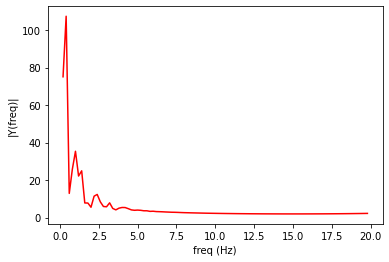

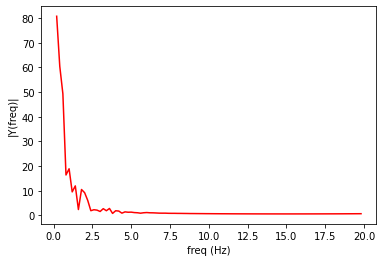

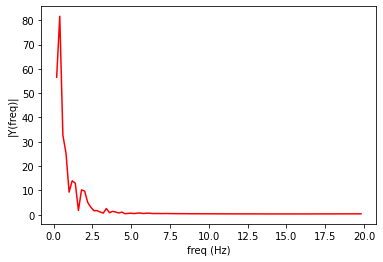

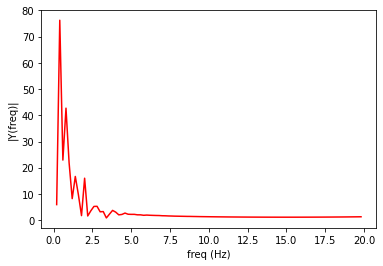

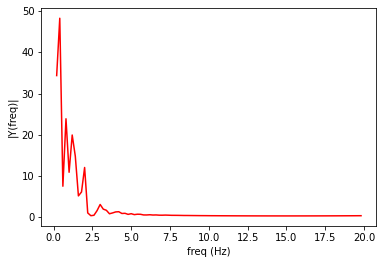

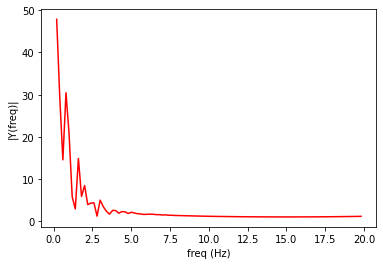

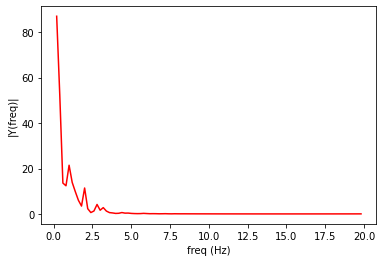

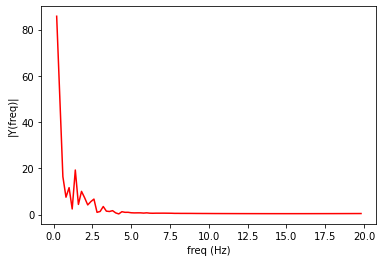

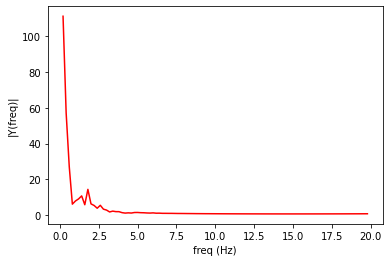

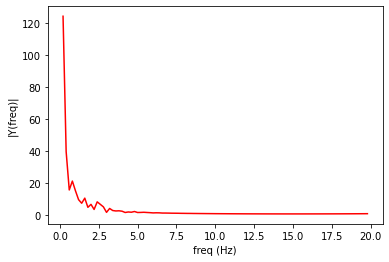

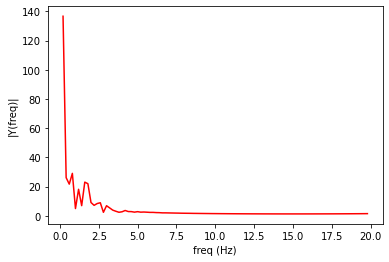

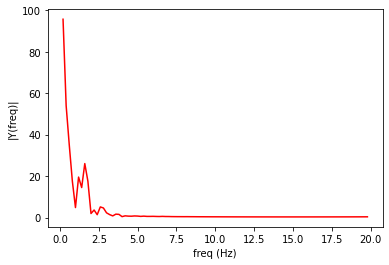

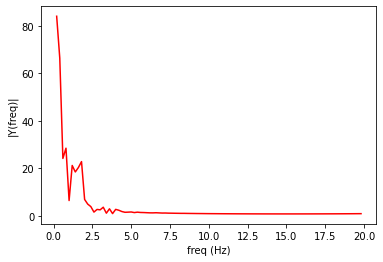

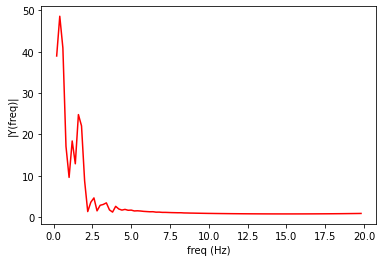

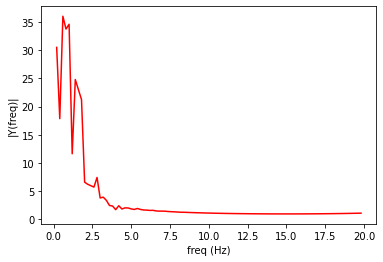

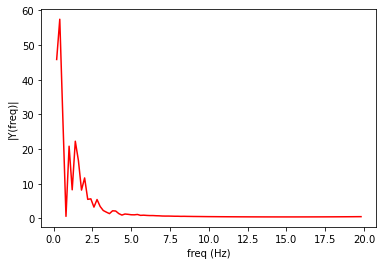

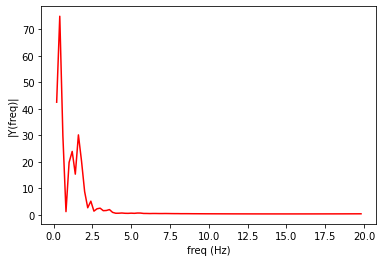

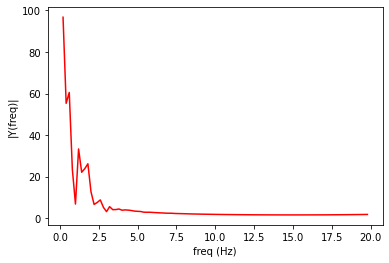

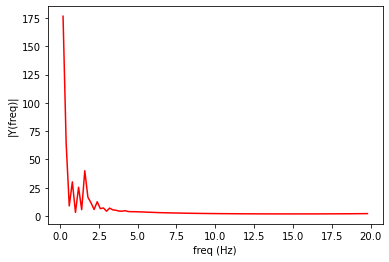

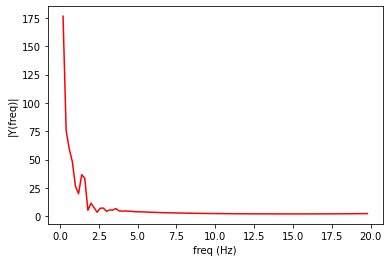

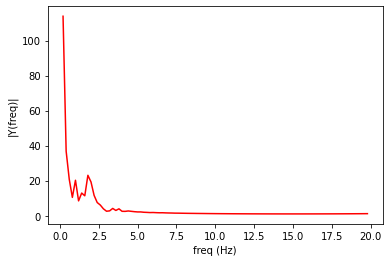

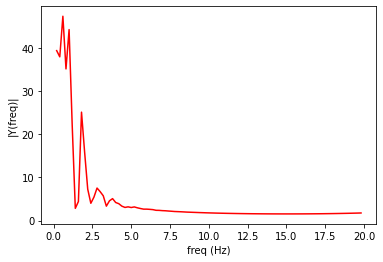

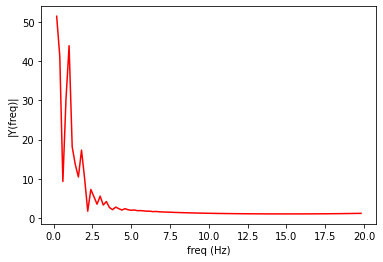

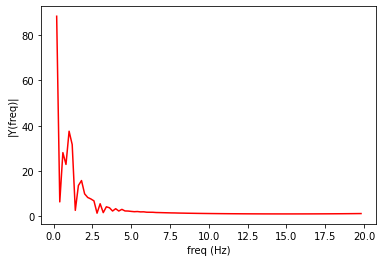

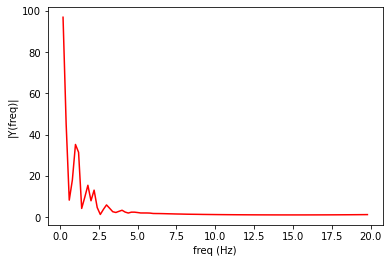

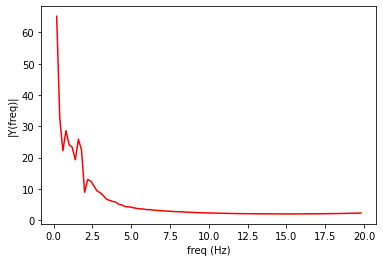

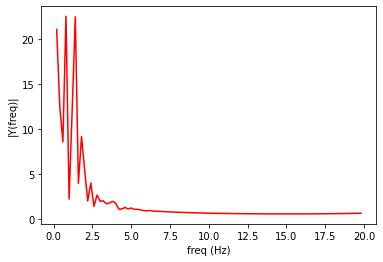

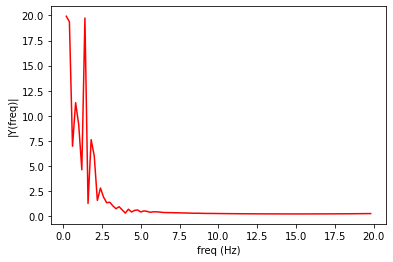

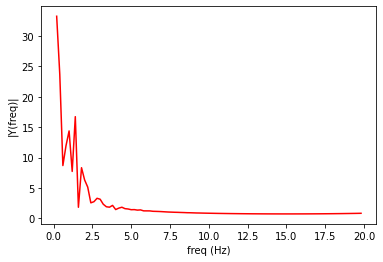

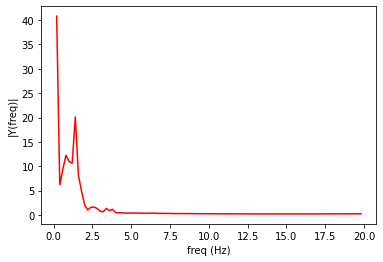

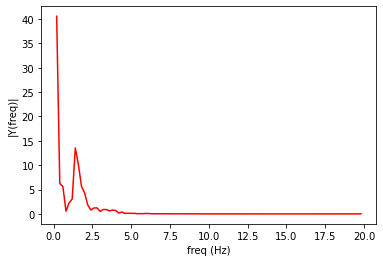

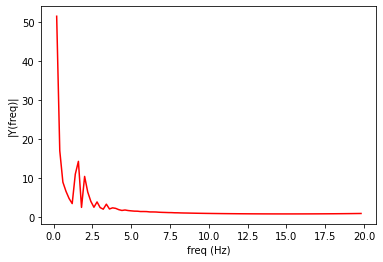

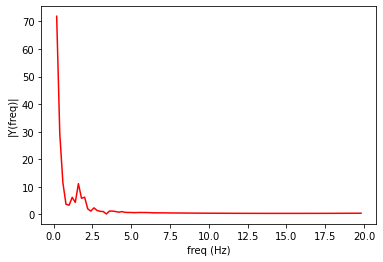

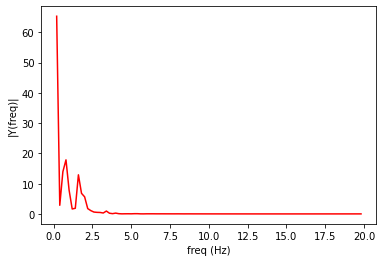

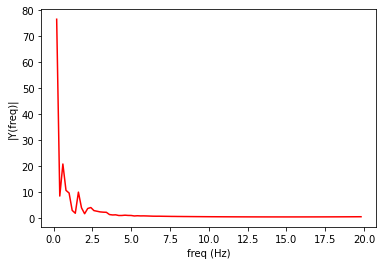

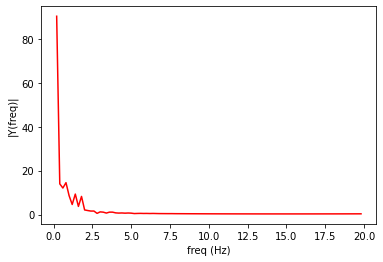

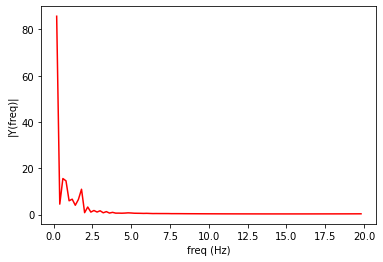

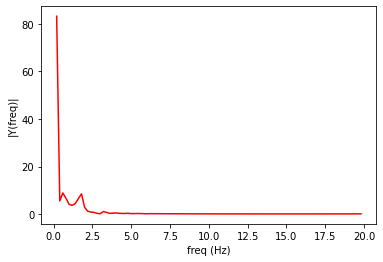

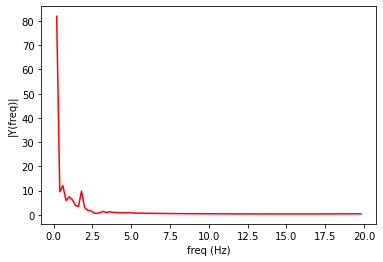

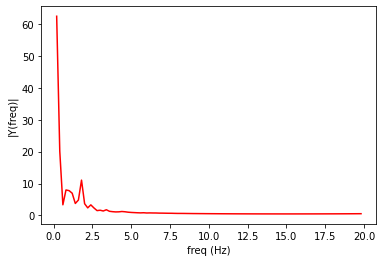

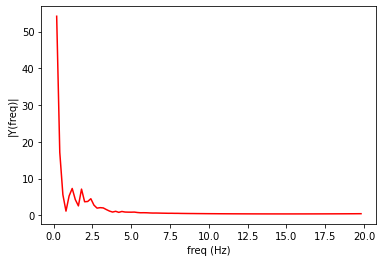

[60.0,
 60.0,
 72.0,
 60.0,
 72.0,
 60.0,
 60.0,
 84.0,
 108.0,
 60.0,
 96.0,
 96.0,
 108.0,
 96.0,
 60.0,
 84.0,
 96.0,
 72.0,
 96.0,
 84.0,
 108.0,
 60.0,
 60.0,
 60.0,
 60.0,
 96.0,
 84.0,
 84.0,
 84.0,
 84.0,
 84.0,
 96.0,
 96.0,
 96.0,
 96.0,
 84.0,
 108.0,
 108.0,
 108.0,
 108.0,
 72.0]

In [74]:
bpmDFT(greenIntensitiesf, 30)